# Project Image Classification on FPGAs
With IoT devices and computer vision algorithms becoming increasingly popular, there are many
applications that can benefit from integrating the two technologies in domains such as smart surveil-
lance, autonomous vehicles, healthcare etc. The main goal is to have quick inference on the edge
device. However two main problems exist:

1. Computer vision algorithms are computationally expensive and power hungry.
2. The majority of CPU’s implemented on IoT devices are not ideal to run these computationally expensive algorithms as the latency is too large and takes a huge amount of power.

In order to mediate these two issues, there has been an extensive amount of research that deals with
how the expensive computation of machine learning models can be offloaded to FPGAs to solve the
issue of latency and power consumption.
The FPGA used in this project is the Zynq®-7000 Artix™-7 FPGA which sits on board the PYNQ-Z2
development board.

The main problem with this FPGA is the amount is the storage capacity, image classification require an
abundant amount of space if you want to achieve a decent accuracy. Therefore, low power / embedded
machine learning techniques such as network pruning and weight quantization are explored in order
to mitigate this problem

### Part 0: All Imports 

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams
import numpy as np
import time
import tensorflow.compat.v2 as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from PIL import Image
import pandas as pd

from models import *
from qkeras.autoqkeras.utils import print_qmodel_summary

import tensorflow_model_optimization as tfmot
from tensorflow_model_optimization.sparsity import keras as sparsity
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_callbacks

from qkeras.utils import _add_supported_quantized_objects
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_wrapper

from tensorflow_model_optimization.sparsity.keras import strip_pruning
import tensorflow as tf

from qkeras.utils import _add_supported_quantized_objects

import hls4ml

2023-06-13 16:09:21.958394: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-13 16:09:22.953181: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


/home/anshul/anaconda3/envs/hls4ml-tutorial/lib/python3.10/site-packages/hls4ml/converters/__init__.py:24: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!", stacklevel=1)


### Part 1 Visualize Dataset

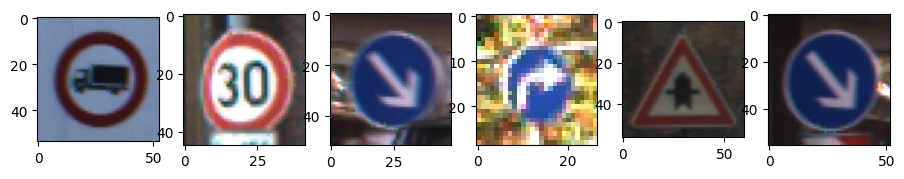

In [2]:


%matplotlib inline

# figure size in inches optional
rcParams['figure.figsize'] = 11 ,8

# read images
img_A = mpimg.imread('/home/anshul/data/Test/00000.png')
img_B = mpimg.imread('/home/anshul/data/Test/00001.png')
img_C = mpimg.imread('/home/anshul/data/Test/00002.png')
img_D = mpimg.imread('/home/anshul/data/Test/00003.png')
img_E = mpimg.imread('/home/anshul/data/Test/00004.png')
img_F = mpimg.imread('/home/anshul/data/Test/00005.png')

# display images
fig, ax = plt.subplots(1,6)
ax[0].imshow(img_A)
ax[1].imshow(img_B)
ax[2].imshow(img_C)
ax[3].imshow(img_D)
ax[4].imshow(img_E)
ax[5].imshow(img_F)

### Part 2 : Prepare Dataset

The first step is to prepare the training, validation, and test data by loading the image arrays into numpy arrays

In [3]:
# Prep Training and Validation Data
data_path = "/home/anshul/data/Train"
data_list = []
labels_list = []
classes_list = 43
for i in range(classes_list):
    i_path = os.path.join(data_path, str(i)) #0-42
    for img in os.listdir(i_path):
        im = Image.open(i_path +'/'+ img)
        im = im.resize((32,32))
        im = np.array(im)
        data_list.append(im)
        labels_list.append(i)
data = np.array(data_list)
labels = np.array(labels_list)

X_data = (data.astype(np.float32))/255.0
y_data =  to_categorical(np.array(labels))

# Split data
X_train, X_val, Y_train, Y_val = train_test_split(X_data,y_data, test_size=0.2, shuffle=True)


# Prepare the Test Data
i_path = '/home/anshul/data'
df = pd.read_csv('/home/anshul/data/Test.csv')
data_list = []
labels_list = []
for index, row in df.iterrows():
    #print(row['Path'])
    im = Image.open(i_path +'/'+ row['Path'])
    im = im.resize((32,32))
    im = np.array(im)
    data_list.append(im)
    labels_list.append(row['ClassId'])
data = np.array(data_list)
labels = np.array(labels_list)

X_test = (data.astype(np.float32))/255.0
y_test =  to_categorical(np.array(labels))


### Load in the model from models.py

In [14]:
qmodel = model5()
MODEL_NAME = model5.__name__
qmodel.summary()
# Print the quantized layers
print_qmodel_summary(qmodel)

Model: "qkeras"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 convbn_0 (QConv2DBatchnorm)  (None, 32, 32, 4)        33        
                                                                 
 relu_conv_0 (QActivation)   (None, 32, 32, 4)         0         
                                                                 
 convbn_1 (QConv2DBatchnorm)  (None, 30, 30, 4)        165       
                                                                 
 relu_conv_1 (QActivation)   (None, 30, 30, 4)         0         
                                                                 
 convbn_2 (QConv2DBatchnorm)  (None, 28, 28, 4)        165       
                                                                 
 relu_conv_2 (QActivation)   (None, 28, 28, 4)         0    

### Set up pruning for the model

In [15]:
NSTEPS = int(X_data.shape[0] * 0.8) // 32  # 80% train, 10% validation in 10-fold cross validation

print('Number of training steps per epoch is {}'.format(NSTEPS))

# Prune all convolutional and dense layers gradually from 0 to 50% sparsity every 2 epochs,
# ending by the 10th epoch
def pruneFunction(layer):
    pruning_params = {'pruning_schedule': sparsity.PolynomialDecay(initial_sparsity=0.0, final_sparsity=0.50, begin_step=NSTEPS * 2, end_step=NSTEPS * 10, frequency=NSTEPS)}
    if isinstance(layer, tf.keras.layers.Conv2D):
        return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)
    if isinstance(layer, tf.keras.layers.Dense) and layer.name != 'output_dense':
        return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)
    return layer

qmodel_pruned = tf.keras.models.clone_model(qmodel, clone_function=pruneFunction)

Number of training steps per epoch is 980


In [16]:
train = True

n_epochs = 30
if train:
    LOSS = tf.keras.losses.CategoricalCrossentropy()
    OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=3e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=True)

    qmodel_pruned.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=["accuracy"])

    callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=10, verbose=1),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
        pruning_callbacks.UpdatePruningStep(),
        #tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,save_weights_only=True,monitor='val_accuracy',mode='max',save_best_only=True)
        ]           

    history = qmodel_pruned.fit(X_train,Y_train, epochs=n_epochs, validation_data=(X_val,Y_val), callbacks=callbacks, verbose=1)
    end = time.time()

    qmodel_pruned.save(MODEL_NAME+'.h5')

    # Plot
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(MODEL_NAME + ' accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    plt.savefig(MODEL_NAME + '_accuracy.png')
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(MODEL_NAME + ' loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    plt.savefig(MODEL_NAME + '_loss.png')

else:


    co = {}
    _add_supported_quantized_objects(co)
    co['PruneLowMagnitude'] = pruning_wrapper.PruneLowMagnitude
    qmodel_pruned = tf.keras.models.load_model(MODEL_NAME+'.h5', custom_objects=co)



# Check test accuracy

In [17]:
predict_qkeras = qmodel_pruned.predict(X_test)
test_score_qkeras = qmodel_pruned.evaluate(X_test, y_test)

print('QKeras accuracy = {}'.format(test_score_qkeras[1]))

395/395 [==============================] - 4s 8ms/step - loss: 0.7203 - accuracy: 0.8494
QKeras accuracy = 0.8494061827659607


Layer prune_low_magnitude_convbn_0: % of zeros = 0.5
Layer prune_low_magnitude_convbn_1: % of zeros = 0.5
Layer prune_low_magnitude_convbn_2: % of zeros = 0.5
Layer prune_low_magnitude_convbn_3: % of zeros = 0.5
Layer prune_low_magnitude_convbn_4: % of zeros = 0.5
Layer output_dense: % of zeros = 0.0


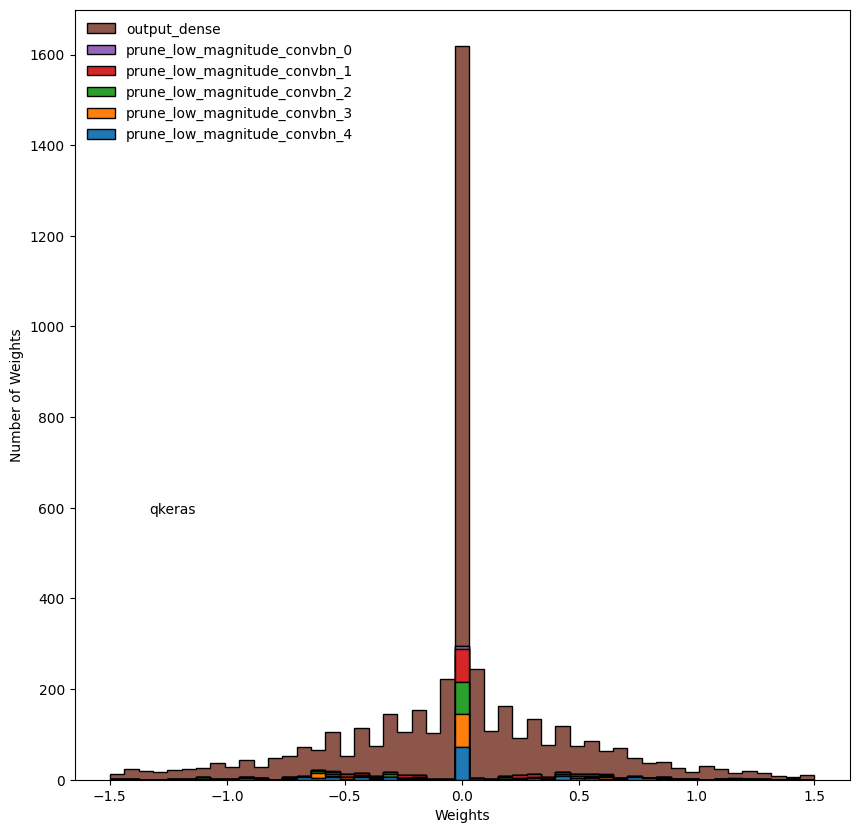

In [18]:
def doWeights(model):

    allWeightsByLayer = {}
    for layer in model.layers:
        if (layer._name).find("batch") != -1 or len(layer.get_weights()) < 1:
            continue
        weights = layer.weights[0].numpy().flatten()
        allWeightsByLayer[layer._name] = weights
        print('Layer {}: % of zeros = {}'.format(layer._name, np.sum(weights == 0) / np.size(weights)))

    labelsW = []
    histosW = []

    for key in reversed(sorted(allWeightsByLayer.keys())):
        labelsW.append(key)
        histosW.append(allWeightsByLayer[key])

    fig = plt.figure(figsize=(10, 10))
    bins = np.linspace(-1.5, 1.5, 50)
    plt.hist(histosW, bins, histtype='stepfilled', stacked=True, label=labelsW, edgecolor='black')
    plt.legend(frameon=False, loc='upper left')
    plt.ylabel('Number of Weights')
    plt.xlabel('Weights')
    plt.figtext(0.2, 0.38, model._name, wrap=True, horizontalalignment='left', verticalalignment='center')


doWeights(qmodel_pruned)

# HLS conversion

The following cells take our trained qkeras model and converts it into HLS code to run on the FPGA

In [ ]:


co = {}
_add_supported_quantized_objects(co)
co['PruneLowMagnitude'] = pruning_wrapper.PruneLowMagnitude

qmodel = tf.keras.models.load_model(MODEL_NAME+'.h5', custom_objects=co)
qmodel = strip_pruning(qmodel) # strip prunning since we dont need it anymore, weights are already zero

In [ ]:


# Then the QKeras model
hls_config_q = hls4ml.utils.config_from_keras_model(qmodel, granularity='name')
hls_config_q['Model']['ReuseFactor'] = 64
cfg_q = hls4ml.converters.create_config(backend='VivadoAccelerator')
cfg_q['IOType'] = 'io_stream'  # Must set this if using CNNs!
cfg_q['HLSConfig'] = hls_config_q
cfg_q['KerasModel'] = qmodel
#cfg_q['OutputDir'] = MODEL_NAME+'/'
cfg_q['OutputDir'] = 'temp'+'/'
cfg_q['XilinxPart'] = 'xc7z020-clg400-1'
cfg_q['ClockPeriod'] = '10'


hls_model_q = hls4ml.converters.keras_to_hls(cfg_q)
hls_model_q.compile()

In [ ]:
hls4ml.model.profiling.numerical(model=qmodel, hls_model=hls_model_q)
hls4ml.utils.plot_model(hls_model_q, show_shapes=True, show_precision=True, to_file=None)

In [ ]:
X_test_1500 = X_test[:1500]
Y_test_1500 = y_test[:1500]

np.save('./x_test.npy', X_test_1500)
np.save('./y_test.npy', Y_test_1500)
import time

# Run Prediction
with tf.device('/cpu:0'):
    start_time = time.time()
    y_predict_q = qmodel.predict(X_test_1500)
    print("--- %s seconds ---" % (time.time() - start_time))

y_predict_hls4ml_q = hls_model_q.predict(np.ascontiguousarray(X_test_1500))

# Get test accuracy
accuracy_keras = float(accuracy_score(np.argmax(Y_test_1500, axis=1), np.argmax(y_predict_q, axis=1)))
accuracy_hls4ml = float(accuracy_score(np.argmax(Y_test_1500, axis=1), np.argmax(y_predict_hls4ml_q, axis=1)))

print("Accuracy Keras:  {}".format(accuracy_keras))
print("Accuracy hls4ml: {}".format(accuracy_hls4ml))

In [ ]:
# import plotting
# from sklearn.metrics import accuracy_score


# def plotROC(Y, y_pred, y_pred_hls4ml, label="Model"):

#     accuracy_keras = float(accuracy_score(np.argmax(Y, axis=1), np.argmax(y_pred, axis=1)))
#     accuracy_hls4ml = float(accuracy_score(np.argmax(Y, axis=1), np.argmax(y_pred_hls4ml, axis=1)))

#     print("Accuracy Keras:  {}".format(accuracy_keras))
#     print("Accuracy hls4ml: {}".format(accuracy_hls4ml))


# # Plot the pruned and quantized QKeras model
# plotROC(Y_test_reduced, y_predict_q, y_predict_hls4ml_q, label="QKeras")

In [ ]:
hls_model_q.build(csim=False, export=True, bitfile=True)

### Package all neccessary files to run on PYNQ-Z2 board

In [ ]:
!mkdir model5/package/
!cp model5/myproject_vivado_accelerator/project_1.runs/impl_1/design_1_wrapper.bit model5/package/hls4ml_nn.bit
!cp model5/myproject_vivado_accelerator/project_1.srcs/sources_1/bd/design_1/hw_handoff/design_1.hwh model5/package/hls4ml_nn.hwh
!cp model5/axi_stream_driver.py model5/package/
!cp x_test.npy y_test.npy model5/package
!tar -czvf model5/package.tar.gz -C model5/package/ .

### Run the deploy and run script. This deploys all necessary files onto both the Rasbperry PI and Pynq-Z2 and runs the inference and reports the Latency and Throughput values

In [ ]:
import subprocess
subprocess.call(['./deploy_and_run.sh'],shell=True)

### The y_hw.npy file is returned by the PYNQ-Z2 which holds the results from the inference, now lets check the accuracy, this value should be very close if not the same to the test accuracy from the pure python model

In [ ]:
import matplotlib.pyplot as plt

%matplotlib inline
from sklearn.metrics import accuracy_score

y_hw = np.load('y_hw.npy')
y_test = np.load('y_test.npy')
y_qkeras = qmodel.predict(X_test_1500)

print("Accuracy QKeras, CPU:     {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_qkeras, axis=1))))
print("Accuracy hls4ml, pynq-z2: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_hw, axis=1))))

